In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

In [3]:
#lets get out asset images from our existing directory 
import re
base_dir = os.getcwd();
enhanced_dir = os.path.join(base_dir, "enhanced_images")
images1  = [f for f in os.listdir(enhanced_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

loaded_images = {}


for image_name in images1:
    name = re.sub(r'\.\w+$', '', image_name)
    name = name.lower()
    image_path = os.path.join(enhanced_dir, image_name)
    img = Image.open(image_path)
    loaded_images[name] = img
    print(f'loaded image with name {name} and size : {img.size}')

loaded image with name abhinav and size : (512, 512)
loaded image with name ashish and size : (512, 512)
loaded image with name ashish_2 and size : (1200, 1600)
loaded image with name ashish_3 and size : (1200, 1600)
loaded image with name chetan and size : (512, 512)
loaded image with name darshan and size : (512, 512)
loaded image with name kashif and size : (512, 512)
loaded image with name laraib and size : (512, 512)
loaded image with name maaz and size : (512, 512)
loaded image with name manish and size : (512, 512)
loaded image with name manjot and size : (512, 512)
loaded image with name mithilesh and size : (512, 512)
loaded image with name mohammeddanish and size : (512, 512)
loaded image with name nalamothu and size : (512, 512)
loaded image with name nalamothu_2 and size : (1280, 720)
loaded image with name nalamothu_3 and size : (1280, 720)
loaded image with name nalamothu_4 and size : (1280, 720)
loaded image with name navanitha and size : (512, 512)
loaded image with nam

In [4]:
def image_detection(img):
    import mediapipe as mp
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection = 1, min_detection_confidence = 0.5) as face_detector:
        imported_image = img.copy()
        if imported_image.shape[-1] == 4:
            imported_image = cv2.cvtColor(imported_image, cv2.COLOR_RGBA2RGB)
        results = face_detector.process(imported_image)
        frame_height, frame_width, c = imported_image.shape
        if results.detections:
            l = len(results.detections)
    
            if l == 0 or results.detections == None:
                print("no person is found in the image")
                return -1, -1
            elif l > 1:
                print("multiple persons are found")
                return -1, -1
            for face in results.detections:
                face_react = np.multiply(
                        [
                            face.location_data.relative_bounding_box.xmin,
                            face.location_data.relative_bounding_box.ymin,
                            face.location_data.relative_bounding_box.width,
                            face.location_data.relative_bounding_box.height,
                        ],[frame_width, frame_height, frame_width, frame_height]).astype(int)
                
                cv2.rectangle(imported_image, face_react, color=(255, 255, 255), thickness=2)
                key_points = np.array([(p.x, p.y) for p in face.location_data.relative_keypoints])
                key_points_coords = np.multiply(key_points,[frame_width,frame_height]).astype(int)
                i = 1
                for p in key_points_coords:
                    # if i == 2 or i == 1:
                    #     continue
                    cv2.circle(imported_image, p, 4, (255, 255, 255), 2)
                    cv2.circle(imported_image, p, 2, (0, 0, 0), -1)
                    i += 1
                
                return face_react, key_points_coords

            return -1, -1

        return -1, -1


# one and two are the coordinates for the eyes in the relative_keypoints and this model is identifying the persons accurately
    

In [5]:
def draw_mesh(img):
    import mediapipe as mp
    #now we are using media pipe's face mesh for accurate facial landmarks in the image
    from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION
    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh
    
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    with mp_face_mesh.FaceMesh(static_image_mode=True, min_detection_confidence=0.5) as face_mesh:
        image = img.copy()
        if image[-1].shape == 4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
        annotated_image = image.copy()
        # print(results.multi_face_landmarks)
        if results.multi_face_landmarks == None:
            print("faces not detected for drawing mesh")
            return 0
        for face_landmarks in results.multi_face_landmarks:
          mp_drawing.draw_landmarks( image=annotated_image,landmark_list=face_landmarks,connections=FACEMESH_TESSELATION,
              landmark_drawing_spec=drawing_spec,
              connection_drawing_spec=drawing_spec)
        return annotated_image

In [6]:

def align_face(image, keypoints):
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']

    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    center_x, center_y = (int((left_eye[0] + right_eye[0]) // 2), int((left_eye[1] + right_eye[1]) // 2))

    rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), angle=angle, scale=1.0)
    aligned_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    return aligned_image


In [7]:
#lets do a little experimentation to find the exact eye pointings in the image in relative key points
def align_detect_image(img, keypoints):
    aligned_image = align_face(img, keypoints)
    r2, c2 = image_detection(aligned_image)
    # print(r2, c2)
    # at this point we have the image that is aligned and its coordinates also, why cant we send  the cropped image from hre
    
    return aligned_image, r2



In [8]:
!pip install keras-facenet
from keras_facenet import FaceNet
embedder = FaceNet()


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import os
import cv2
import numpy as np
from gfpgan import GFPGANer

# Set up GFPGANer
base_path = os.getcwd()
# inter_path = os.path.join(base_path, "models");
model_path = r"D:\venv's\frs\models\GFPGANv1.4.pth"
gfpganer = GFPGANer(
    model_path=model_path,
    upscale=2,  # Upscaling factor
    arch="clean",  # For general restoration
    channel_multiplier=2  # Default channel multiplier
)

def enhance_faces(input_img):
    # Use the correct variable for input image
    result = gfpganer.enhance(input_img, has_aligned=False, only_center_face=False)
    
    if isinstance(result, tuple):
        restored_image = result[1][0]  # Access the first restored image
        if isinstance(restored_image, np.ndarray):
            # Ensure the restored image has correct data type
            if restored_image.dtype != np.uint8:
                restored_image = np.clip(restored_image, 0, 255).astype(np.uint8)
        return restored_image
    else:
        print("Unexpected result format from GFPGAN.")
        return None


D:\venv's\frs\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\venv's\frs\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
D:\venv's\frs\Lib\site-packages\facexlib\detection\__init__.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limi

In [10]:
# now we can write a function for similarity between the embeddings in two images , based on that we can set certain treshold for that
#lets find the embedding of two similar images and calculate the cosine between them

def cosine_similarity(embedding1, embedding2):

    embedding1 = embedding1.flatten()
    embedding2 = embedding2.flatten()


    dot_product = np.dot(embedding1, embedding2)
    norm_embedding1 = np.linalg.norm(embedding1)
    norm_embedding2 = np.linalg.norm(embedding2)
    similarity = dot_product / (norm_embedding1 * norm_embedding2)
    return similarity

In [24]:
img1 = np.array(loaded_images['vennela2'].copy())
img2 = np.array(loaded_images['vennela2'].copy())



result1, c1 = image_detection(img1)
result2, c2 = image_detection(img2)

print(result1, c1)
print(result2, c2)

if type(c1) == int or type(c2) == int:
    print("face not detected in one or more images")
else:
    keypoints1 = {}
    keypoints1['left_eye'] = c1[0]
    keypoints1['right_eye'] = c1[1]
    
    keypoints2 = {}
    keypoints2['left_eye'] = c2[0]
    keypoints2['right_eye'] = c2[1]
    
    
    cropped_img1 = img1.copy()
    cropped_img2 = img2.copy()
    
    ares1, ares2 = -1, -1
    
    if type(result1) == int:
        print("no persons or multiple persons in image1")
    else:
        aligned_image1, ares1 = align_detect_image(img1, keypoints1)
        x, y, h, w = ares1
        cropped_img1 = aligned_image1[y:y+h, x:x+w]
        cropped_img1_enhanced = enhance_faces(cropped_img1)
    
    if type(result2) == int:
        print("no persons or multiple persons in image2")
    else:
        aligned_image2, ares2 = align_detect_image(img2, keypoints2)
        x, y, h, w = ares2
        cropped_img2 = aligned_image2[y:y+h, x:x+w]
        cropped_img2_enhanced = enhance_faces(cropped_img2)

    print(ares1, ares2)
        
    
    if type(ares1) != int and type(ares2) != int:
        im1_embedding = embedder.embeddings([cropped_img1_enhanced])
        im2_embedding = embedder.embeddings([cropped_img2_enhanced])
        
        cosine_similar = cosine_similarity(im1_embedding, im2_embedding)
        print(cosine_similar)
    else:
        print("person is not found in the image")

[320 628  83  83] [[344 649]
 [375 651]
 [360 668]
 [366 687]
 [337 668]
 [404 666]]
[320 628  83  83] [[344 649]
 [375 651]
 [360 668]
 [366 687]
 [337 668]
 [404 666]]
[321 633  82  82] [321 633  82  82]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
0.99998087


In [15]:
#this block of code is for getting the embeddings of all the people in the images, that is our employess data

def get_embeddings():
    embeddings = {}
    for key, value in loaded_images.items():
        image = np.array(value).copy()
        results, c = image_detection(image)
        keypoints = {}
        keypoints['left_eye'] = c[0]
        keypoints['right_eye'] = c[1]
        aligned_image, coords = align_detect_image(image, keypoints)
        x, y, h, w = coords
        plt.imshow(aligned_image)
        cropped_image = aligned_image[y:y+h, x:x+w]
        embed = embedder.embeddings([cropped_image])
        embeddings[key] = embed
    return embeddings


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

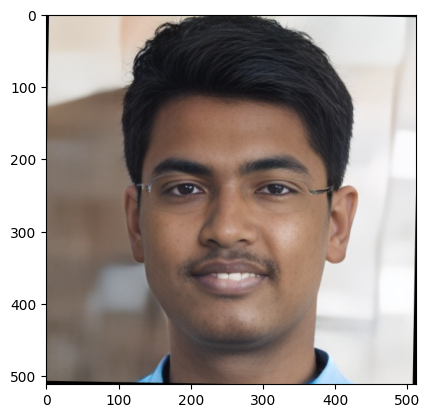

In [26]:
embeddings = get_embeddings()
for key, value in embeddings.items():
    print(f'name : {key} , embeddings = {value.shape}')

In [17]:
print(embeddings['nalamothu'].shape)

(1, 512)


In [21]:
import json

# Convert embeddings into a JSON-serializable format (lists)
face_embeddings = {key: value.tolist() if isinstance(value, (np.ndarray, list)) else value for key, value in embeddings.items()}

# Write the embeddings to a file
with open('face_embeddings.json', 'w') as f:
    json.dump(face_embeddings, f)

print("Embeddings saved successfully to face_embeddings.json")

Embeddings saved successfully to face_embeddings.json


In [23]:
import json

with open('face_embeddings.json', 'r') as f:
    face_embeddings = json.load(f)

if "nalamothu_2" in face_embeddings:
    del face_embeddings["nalamothu_2"]

if "nalamothu_3" in face_embeddings:
    del face_embeddings["nalamothu_3"]

if "nalamothu_4" in face_embeddings:
    del face_embeddings["nalamothu_4"]

if "ashish_2" in face_embeddings:
    del face_embeddings["ashish_2"]

if "ashish_3" in face_embeddings:
    del face_embeddings["ashish_3"]

with open('face_embeddings.json', 'w') as f:
    json.dump(face_embeddings, f, indent=4)

print("JSON file updated successfully!")


JSON file updated successfully!


In [25]:
for keys in embeddings.keys():
    print(keys)

abhinav
ashish
ashish_2
ashish_3
chetan
darshan
kashif
laraib
maaz
manish
manjot
mithilesh
mohammeddanish
nalamothu
nalamothu_2
nalamothu_3
nalamothu_4
navanitha
ootala
pavankumar
rahul
rohit
rushi
rutuparna
samdonald
sinjinee
sudhir
sushant
vaishali
yash
